# Export LaMa inpainting model to ONNX


Author: [Nikita Selin](https://github.com/OPHoperHPO), [Carve.Photos Team](https://carve.photos) \
HuggingFace Repository with ONNX Model: [Link](https://huggingface.co/Carve/LaMa-ONNX) \
Original repository: [Link](https://github.com/advimman/lama)




## install deps

In [1]:
!git clone https://github.com/Carve-Photos/lama --depth 1

Cloning into 'lama'...
remote: Enumerating objects: 249, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 249 (delta 53), reused 133 (delta 48), pack-reused 0 (from 0)
Receiving objects: 100% (249/249), 5.68 MiB | 10.38 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [2]:
%cd lama

/content/lama


In [3]:
!curl -LJO https://huggingface.co/smartywu/big-lama/resolve/main/big-lama.zip
!unzip big-lama.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1171  100  1171    0     0   1903      0 --:--:-- --:--:-- --:--:--  1904
100  363M  100  363M    0     0  25.7M      0  0:00:14  0:00:14 --:--:-- 28.6M
Archive:  big-lama.zip
  inflating: big-lama/config.yaml    
  inflating: big-lama/models/best.ckpt  


In [4]:
!pip3 install omegaconf webdataset pytorch_lightning pytorch_lightning kornia==0.5.0 onnx onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.5/271.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
  

In [2]:
!pip install albumentations==0.4.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 29.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.4/631.4 kB 33.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.3-py3-none-any.whl size=60757 sha256=08ce641891879b25135e42b1b20a59c05ca5d908988685db4fd8fd42add5f9b2
  Stored in directory: /root/.cache/pip/wheels/64/5b/e1/875c576672874835ecbbf1107463d6d0b9665cf77f460da3f7
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654004 sha256=450e66066404392475ad3ce20f6c6e0fbc5cbeb9690a603a06854daa64c20f09
  Stored in directory: /root/.cache/pip/wheels/ec/82/dc/ed45b805daac0354f5e10a19b3fc2ca22bcac4429b010a3088
Successfully built albumentations imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.4.0
    Uninstalling imgaug-0.4.0:
      Successfully uninstalled imgaug-0.4.0
  Attempting uninstall: albument

## init model

In [1]:
import torch
from omegaconf import OmegaConf
from yaml import safe_load
import sys
sys.path.append("/content/lama/")

from saicinpainting.training.trainers.default import (
    DefaultInpaintingTrainingModule,
)


class ExportLama(torch.nn.Module):
    def forward(self, image: torch.Tensor, mask: torch.Tensor):
        masked_img = image * (1 - mask)

        if self.model.concat_mask:
            masked_img = torch.cat([masked_img, mask], dim=1)

        predicted_image = self.model.generator(masked_img)
        inpainted = mask * predicted_image + (1 - mask) * image
        return torch.clamp(inpainted * 255, min=0, max=255)

Detectron v2 is not installed


## export onnx

In [2]:
# Load the configuration file
config = OmegaConf.create(safe_load(open("/content/lama/big-lama/config.yaml")))

# Extract and modify training model configuration
kwargs = dict(config.training_model)
kwargs.pop("kind")
kwargs["use_ddp"] = True

# Enable JIT version of FourierUnit, required for export
config.generator.resnet_conv_kwargs.use_jit = True

# Fix the configuration by setting the weight to zero
config.losses.resnet_pl.weight = 0

# Load the model state
state = torch.load("/content/lama/big-lama/models/best.ckpt", map_location="cpu")
lama_dilated_model = DefaultInpaintingTrainingModule(config, **kwargs)
lama_dilated_model.load_state_dict(state["state_dict"], strict=False)
lama_dilated_model.on_load_checkpoint(state)
lama_dilated_model.freeze()
lama_dilated_model.eval()

# Export the model
exported_model = ExportLama()
exported_model.register_module("model", lama_dilated_model)
exported_model.eval()
exported_model.to("cpu")

# Export to ONNX format
torch.onnx.export(
    exported_model,
    (
        torch.rand(1, 3, 512, 512).type(torch.float32).to("cpu"),  # Change resolution here! If you get a tensor size mismatch, you need to specify correct padding (see FourierUnitJIT)
        torch.rand(1, 1, 512, 512).type(torch.float32).to("cpu")
    ),
    "/content/lama_fp32.onnx",
    input_names=["image", "mask"],
    output_names=["output"],
    dynamic_axes={
        "image": {0: "batch"},
        "mask": {0: "batch"},
        "output": {0: "batch"}
    },  # TODO: Adapt FourierUnit to support dynamic axes (see irfttn and rfft for correct padding)
    export_params=True,
    do_constant_folding=True,
    opset_version=17,
    verbose=False,
)

print("Lama Model exported to /content/lama_fp32.onnx (open file explorer to download)")


<ipython-input-2-6709f1d4e706>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("/content/lama/big-lama/models/best.ckpt", map_location="cpu")
/usr/local

Lama Model exported to /content/lama_fp32.onnx (open file explorer to download)


## Test exported onnx model

In [3]:
import cv2
import numpy as np
import onnxruntime
import torch
import io
import requests
from PIL import Image

def get_image(image):
    if isinstance(image, Image.Image):
        img = np.array(image)
    elif isinstance(image, np.ndarray):
        img = image.copy()
    else:
        raise Exception("Input image should be either PIL Image or numpy array!")

    if img.ndim == 3:
        img = np.transpose(img, (2, 0, 1))  # chw
    elif img.ndim == 2:
        img = img[np.newaxis, ...]

    assert img.ndim == 3

    img = img.astype(np.float32) / 255
    return img


def ceil_modulo(x, mod):
    if x % mod == 0:
        return x
    return (x // mod + 1) * mod


def scale_image(img, factor, interpolation=cv2.INTER_AREA):
    if img.shape[0] == 1:
        img = img[0]
    else:
        img = np.transpose(img, (1, 2, 0))

    img = cv2.resize(img, dsize=None, fx=factor, fy=factor, interpolation=interpolation)

    if img.ndim == 2:
        img = img[None, ...]
    else:
        img = np.transpose(img, (2, 0, 1))
    return img


def pad_img_to_modulo(img, mod):
    channels, height, width = img.shape
    out_height = ceil_modulo(height, mod)
    out_width = ceil_modulo(width, mod)
    return np.pad(
        img,
        ((0, 0), (0, out_height - height), (0, out_width - width)),
        mode="symmetric",
    )


def prepare_img_and_mask(image, mask, device, pad_out_to_modulo=8, scale_factor=None):
    out_image = get_image(image)
    out_mask = get_image(mask)

    if scale_factor is not None:
        out_image = scale_image(out_image, scale_factor)
        out_mask = scale_image(out_mask, scale_factor, interpolation=cv2.INTER_NEAREST)

    if pad_out_to_modulo is not None and pad_out_to_modulo > 1:
        out_image = pad_img_to_modulo(out_image, pad_out_to_modulo)
        out_mask = pad_img_to_modulo(out_mask, pad_out_to_modulo)

    out_image = torch.from_numpy(out_image).unsqueeze(0).to(device)
    out_mask = torch.from_numpy(out_mask).unsqueeze(0).to(device)

    out_mask = (out_mask > 0) * 1

    return out_image, out_mask

def open_image(image):
    if isinstance(image, str):
      if image.startswith("http://") or image.startswith("https://"):
        image = Image.open(io.BytesIO(requests.get(image).content))
      else:
        image = Image.open(image)
    return image





In [4]:
sess_options = onnxruntime.SessionOptions()
model = onnxruntime.InferenceSession('/content/lama_fp32.onnx', sess_options=sess_options)


In [18]:
!pip install pytesseract
!apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 21 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 3s (1,770 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [32]:
import pytesseract
from PIL import Image
import cv2
import numpy as np

# Load the image
img_path = '/content/images.png'
image = cv2.imread(img_path)

# Convert to grayscale (optional but often improves OCR accuracy)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Extract text and bounding boxes
custom_config = r'--oem 3 --psm 6'
text_data = pytesseract.image_to_data(gray, output_type='dict', config=custom_config)

# Extract bounding boxes
boxes = []
for i in range(len(text_data['text'])):
    if int(float(text_data['conf'][i])) > 40:  # Filter by confidence level
        (x, y, w, h) = (text_data['left'][i], text_data['top'][i], text_data['width'][i], text_data['height'][i])
        boxes.append((x, y, x + w, y + h))

# Create a mask image with the same size as the original image
mask = np.zeros_like(image)

# Draw bounding boxes on the mask
for box in boxes:
    cv2.rectangle(mask, (box[0], box[1]), (box[2], box[3]), (255, 255, 255), -1)

# Save the mask
cv2.imwrite('/content/mask_image_5.png', mask)


True

In [35]:
#@title predict with onnx model
# image_url = "https://huggingface.co/Carve/LaMa-ONNX/resolve/main/image.jpg" # @param {type:"string"}
# mask_url = "https://huggingface.co/Carve/LaMa-ONNX/resolve/main/mask.png" # @param {type:"string"}

# Load the image and mask
# image = Image.open('image_text.jpg')
# mask = Image.open('mask_image.png')

# Convert to tensors
# image_tensor = torch.from_numpy(np.array(image)).permute(2, 0, 1).unsqueeze(0).float() / 255.0
# mask_tensor = torch.from_numpy(np.array(mask)).unsqueeze(0).unsqueeze(0).float() / 255.0

# image = open_image(image_url).resize((512, 512))
# mask = open_image(mask_url).convert("L").resize((512, 512))

image = Image.open('/content/images.png')
mask = Image.open('/content/mask_image_5.png')
image = image.resize((512, 512))
mask = mask.convert("L").resize((512, 512))


image, mask = prepare_img_and_mask(image, mask, 'cpu')
# Run the model
outputs = model.run(None,
                    {'image': image.numpy().astype(np.float32),
                     'mask': mask.numpy().astype(np.float32)})

output = outputs[0][0]
# Postprocess the outputs
output = output.transpose(1, 2, 0)
output = output.astype(np.uint8)
output = Image.fromarray(output)
# output

(512, 512)
(512, 512)


InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: image for the following indices
 index: 1 Got: 1 Expected: 3
 Please fix either the inputs/outputs or the model.

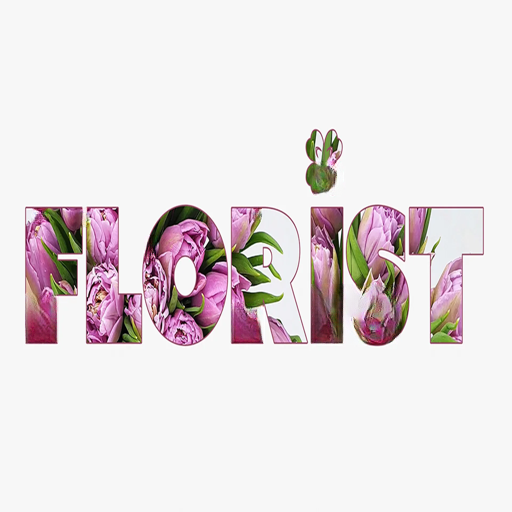

In [31]:
output